In [4]:
import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
print(tf.__version__)

1.15.0


In [0]:
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
np.random.seed(203)



In [7]:
from google.colab import files
files.upload()

Saving creditcard.csv to creditcard.csv


In [0]:
dataset = pd.read_csv("creditcard.csv")


dataset['Amount'] = np.log(dataset['Amount'] + 1)
dataset['Time'] = np.log(dataset['Time'] + 1)

from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

dataset['Amount'] = rob_scaler.fit_transform(dataset['Amount'].values.reshape(-1,1))
dataset['Time'] = rob_scaler.fit_transform(dataset['Time'].values.reshape(-1,1))



In [20]:


normal = dataset[dataset['Class'] == 0]
anomaly = dataset[dataset['Class'] == 1]
print(normal.shape)
print(anomaly.shape)

from sklearn.model_selection import train_test_split

train, normal_test, _, _ = train_test_split(normal, normal, test_size=.9, random_state=42)

normal_valid, normal_test, _, _ = train_test_split(normal_test, normal_test, test_size=.5, random_state=42)
anormal_valid, anormal_test, _, _ = train_test_split(anomaly, anomaly, test_size=.5, random_state=42)


train = train.reset_index(drop=True)
valid = normal_valid.append(anormal_valid).sample(frac=1).reset_index(drop=True)
test = normal_test.append(anormal_test).sample(frac=1).reset_index(drop=True)


print('Train shape: ', train.shape)
print('Proportion of anomaly in training set: %.2f\n' % train['Class'].mean())
print('Valid shape: ', valid.shape)
print('Proportion of anomaly in validation set: %.2f\n' % valid['Class'].mean())
print('Test shape:, ', test.shape)
print('Proportion of anomaly in test set: %.2f\n' % test['Class'].mean())


#X = train.drop(['Class'], axis = 1).values
#y = train["Class"].values

#print('X shape: ', X.shape)
#print('y shape: ', y.shape)


(284315, 31)
(492, 31)
Train shape:  (28431, 31)
Proportion of anomaly in training set: 0.00

Valid shape:  (128188, 31)
Proportion of anomaly in validation set: 0.00

Test shape:,  (128188, 31)
Proportion of anomaly in test set: 0.00



In [0]:
np.random.seed(203)

In [23]:
normal = valid[valid['Class']==0].append(test[test['Class']==0]).sample(1000).reset_index(drop=True)
anomaly = valid[valid['Class']==1].append(test[test['Class']==1]).reset_index(drop=True)
data1 = normal.append(anomaly)
X = data1.drop('Class', axis=1)
y = data1['Class']
print('X shape: ', X.shape)
print('y shape: ', y.shape)

X shape:  (1492, 30)
y shape:  (1492,)


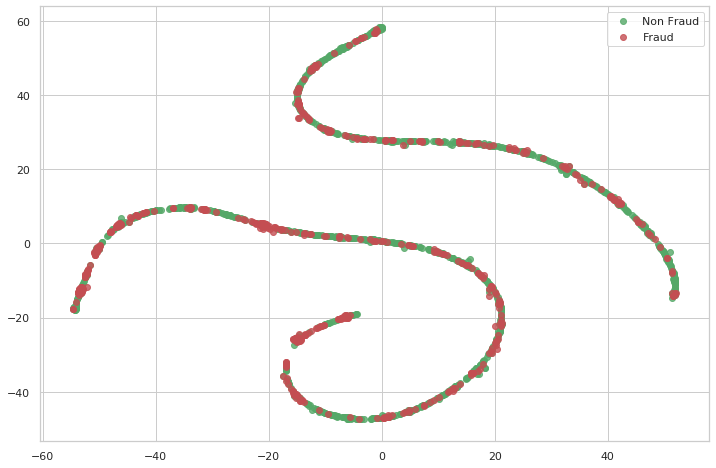

In [24]:
from sklearn.manifold import TSNE

def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')

    plt.legend(loc='best');
    plt.savefig(name);
    plt.show();
    
tsne_plot(X, y, "original.png")

In [0]:
## input layer 
input_layer = Input(shape=(train.drop('Class', axis=1).shape[1],))

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

## decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

## output layer
output_layer = Dense(train.drop('Class', axis=1).shape[1], activation='relu')(decoded)

autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")



#x = data.drop(["Class"], axis=1)
#y = data["Class"].values

#x_scale = preprocessing.MinMaxScaler().fit_transform(x.values)
#x_norm, x_fraud = x_scale[y == 0], x_scale[y == 1]



autoencoder.fit(train.drop('Class', axis=1), train.drop('Class', axis=1), 
                batch_size = 256, epochs = 10, 
                shuffle = True, validation_split = 0.20);

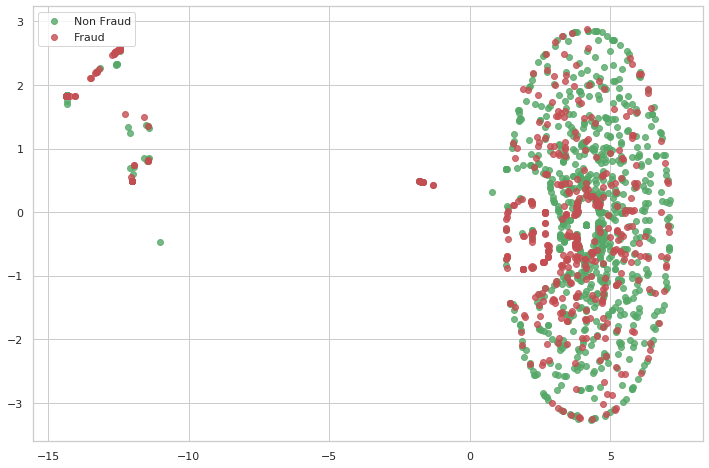

In [25]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

hid_rep = hidden_representation.predict(X) 
tsne_plot(hid_rep, y, "latent_representation.png")


In [21]:

clf = LogisticRegression(solver="lbfgs").fit(valid.drop('Class', axis=1), valid['Class'])
pred_y = clf.predict(test.drop('Class', axis=1))

print ("")
print ("Classification Report: ")
print (classification_report(test['Class'], pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(test['Class'], pred_y))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    127942
           1       0.73      0.70      0.71       246

    accuracy                           1.00    128188
   macro avg       0.87      0.85      0.86    128188
weighted avg       1.00      1.00      1.00    128188


Accuracy Score:  0.9989234561737448
